#### Assignment - 1
##### Name : Chunduru Sai Pranav
##### Roll No : 2020101033

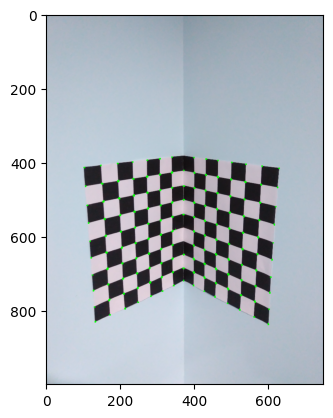

In [39]:
## Question - 1
# 1.1

import cv2
import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread('calib-object.jpg')

max_dim = 1000
scale = max_dim / max(image.shape[0], image.shape[1])

final = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))
gray = cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)

corners = cv2.cornerHarris(gray, 2, 3, 0.04)
corners = cv2.dilate(corners, None)
final[corners > 0.01 * corners.max()] = [0, 255, 0]

plt.imshow(final)


In [40]:
# 1.2

image_pts = [[1539, 2852],[2057, 2411],[1660, 1610],[2360, 2881],[1416, 2278],[2402, 2120],[2237, 1887],[1159, 2857]]
obj_pts = [[0, 2, 0], [8, 10, 0], [2, 18, 0], [12, 6, 0], [0, 10, 2], [12, 14, 0], [10, 16, 0], [0, 4, 6]]

def compute_projection_matrix(img_coords, obj_coords):
    matrix_elements = []

    for index in range(len(img_coords)):
        x, y = img_coords[index]
        X, Y, Z = obj_coords[index]

        row_one = [X, Y, Z,  1,  0,  0,  0,  0, -x * X, -x * Y, -x * Z, -x]
        row_two = [0,  0,  0,  0, X, Y, Z,  1, -y * X, -y * Y, -y * Z, -y]

        matrix_elements.extend([row_one, row_two])

    matrix_elements = np.array(matrix_elements)
    _, _, V = np.linalg.svd(matrix_elements)
    P = V[-1, :] / V[-1, -1]
    P = P.reshape(3,  4)
    return P

def separate_projection_matrix(proj_mat):
    K = np.zeros((3,  3))
    M = proj_mat[:, :3]

    MT = np.dot(M, M.T)
    MT /= MT[-1, -1]
    K[2,  2] =  1
    K[0,  2] = MT[0,  2]
    K[1,  2] = MT[1,  2]
    K[1,  1] = np.sqrt(MT[1,  1] - K[1,  2] **  2)
    K[0,  0] = np.sqrt(MT[0,  0] - K[0,  2] **  2)
    R = np.dot(np.linalg.inv(K), M)
    T = np.dot(np.linalg.inv(K), proj_mat[:, -1])

    return K, R, T

# Compute the projection matrix
proj_mat = compute_projection_matrix(image_pts, obj_pts)
print("\nProjection matrix:")
print(proj_mat)

# Decompose the projection matrix
K, R, T = separate_projection_matrix(proj_mat)
print("\nIntrinsic matrix:")
print(K)
print("\nRotation matrix:")
print(R)
print("\nTranslation matrix:")
print(T)


Projection matrix:
[[ 3.11113450e+01 -7.65084190e+00 -8.33531484e+01  1.53882629e+03]
 [-1.68682373e+01 -8.56288403e+01 -2.78354804e+01  2.99519237e+03]
 [-1.49776002e-02 -4.88920353e-03 -1.83947894e-02  1.00000000e+00]]

Intrinsic matrix:
[[3.16976322e+03 0.00000000e+00 1.88321648e+03]
 [0.00000000e+00 3.19940398e+03 2.01726582e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Rotation matrix:
[[ 0.01871351  0.00049107 -0.01536764]
 [ 0.00417127 -0.02368129  0.00289795]
 [-0.0149776  -0.0048892  -0.01839479]]

Translation matrix:
[-0.10864855  0.30565898  1.        ]


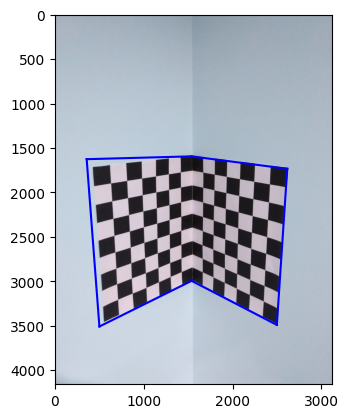

In [41]:
# 1.3

def create_wireframe(vertex_list, transformation_matrix):
    transformed_vertices = []
    vertex_count = len(vertex_list)
    
    for idx in range(vertex_count):
        current_vertex = vertex_list[idx] + [1]
        current_vertex = np.array(current_vertex)
        projected_vertex = np.dot(transformation_matrix, current_vertex)
        projected_vertex /= projected_vertex[-1]
        transformed_vertices.append(projected_vertex[:-1])
    
    transformed_vertices = np.array(transformed_vertices)
    
    for idx in range(vertex_count):
        next_vertex_index = (idx +  1) % vertex_count
        plt.plot([transformed_vertices[idx][0], transformed_vertices[next_vertex_index][0]],
                 [transformed_vertices[idx][1], transformed_vertices[next_vertex_index][1]], 'b')

    image = cv2.imread('calib-object.jpg')
    plt.imshow(image)

corner_points = [[0,  0,  0], [14,  0,  0], [14,  18,  0], [0,  18,  0], [0,  18,  14], [0,  0,  14]]
create_wireframe(corner_points, proj_mat)

In [42]:
# 1.4

def rotation_matrix_to_angles(R, eps=1e-8):
  pan = np.degrees(np.arctan2(R[1, 0], R[0, 0]))

  if abs(R[2, 0]) < eps and abs(R[2, 1]) < eps:
    tilt_x = 0.0
    tilt_y = np.degrees(np.arctan2(R[0, 2], R[1, 2]))
  else:
    tilt_y = np.degrees(np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2)))
    tilt_x = np.degrees(np.arctan2(R[2, 1], R[2, 2]))

  return pan, tilt_x, tilt_y

# Example usage
pan, tilt_x, tilt_y = rotation_matrix_to_angles(R)
print(f"Pan (Z-axis rotation): {pan:.2f} degrees")
print(f"Tilt (X-axis rotation): {tilt_x:.2f} degrees")
print(f"Roll (Y-axis rotation): {tilt_y:.2f} degrees")

Pan (Z-axis rotation): 12.57 degrees
Tilt (X-axis rotation): -165.12 degrees
Roll (Y-axis rotation): 38.20 degrees


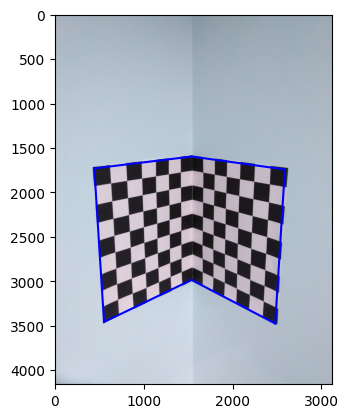

In [43]:
## Question - 2

# 2.1

image = cv2.imread('calib-object.jpg')
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

planar_img_pts=[[1539, 2852], [2057, 2411], [1660, 1610], [2360, 2881], [2402, 2120], [2237, 1887], [1903, 3021], [2066, 2044]]
planar_obj_pts=[[0, 2, 0], [8, 10, 0], [2, 18, 0], [12, 6, 0], [12, 14, 0], [10, 16, 0], [6, 2, 0], [8,14, 0]]

image_size = grey.shape[::-1]

def change_format(planar_img_pts, planar_obj_pts, image_pts, obj_pts):
    planar_img_pts = np.array(planar_img_pts, dtype=np.float32)
    planar_obj_pts = np.array(planar_obj_pts, dtype=np.float32)

    image_pts = np.array(image_pts, dtype=np.float32)
    obj_pts = np.array(obj_pts, dtype=np.float32)

    planar_obj_pts = [planar_obj_pts]
    planar_img_pts = [planar_img_pts]

    obj_pts = [obj_pts]
    image_pts = [image_pts]
    
    return planar_img_pts, planar_obj_pts, image_pts, obj_pts
    
planar_img_pts, planar_obj_pts, image_pts, obj_pts =  change_format(planar_img_pts, planar_obj_pts, image_pts, obj_pts)

x,initial_guess,y,z,w = cv2.calibrateCamera(planar_obj_pts, planar_img_pts, image_size, None, None)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, image_pts, image_size,initial_guess, None, flags=cv2.CALIB_USE_INTRINSIC_GUESS)

R = cv2.Rodrigues(rvecs[0])[0]
T = tvecs[0]
P=np.dot(mtx,np.hstack((R,T)))

corner_points = [[0,  0,  0], [14,  0,  0], [14,  18,  0], [0,  18,  0], [0,  18,  14], [0,  0,  14]]
create_wireframe(corner_points, P)

## 2.1 
 
We observe a more accurate wireframe.


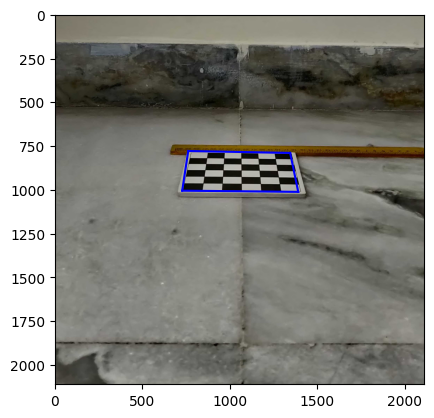

In [44]:
# 2.2

img = cv2.imread('assign1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

P = [[ 2.20244443e+03,  4.46439330e+02, -8.04387868e+02,  2.75047592e+04],
 [ 1.03713589e+02, -3.69404406e+02, -1.34822956e+03,  3.80159120e+04],
 [ 8.12141431e-02,  4.42951810e-01, -8.92859427e-01,  3.78210097e+01]]

outer_corners=[[0,0,0],[12,0,0],[12,12,0],[0,12,0]]

def create_wireframe2(vertex_list, transformation_matrix):
    transformed_vertices = []
    vertex_count = len(vertex_list)
    
    for idx in range(vertex_count):
        current_vertex = vertex_list[idx] + [1]
        current_vertex = np.array(current_vertex)
        projected_vertex = np.dot(transformation_matrix, current_vertex)
        projected_vertex /= projected_vertex[-1]
        transformed_vertices.append(projected_vertex[:-1])
    
    transformed_vertices = np.array(transformed_vertices)
    
    for idx in range(vertex_count):
        next_vertex_index = (idx +  1) % vertex_count
        plt.plot([transformed_vertices[idx][0], transformed_vertices[next_vertex_index][0]],
                 [transformed_vertices[idx][1], transformed_vertices[next_vertex_index][1]], 'b')

    image = cv2.imread('assign1.jpg')
    plt.imshow(image)

create_wireframe2(outer_corners, P)

plt.imshow(img)

[[1349  796]
 [2061  799]
 [2144 1017]
 [1402 1014]]


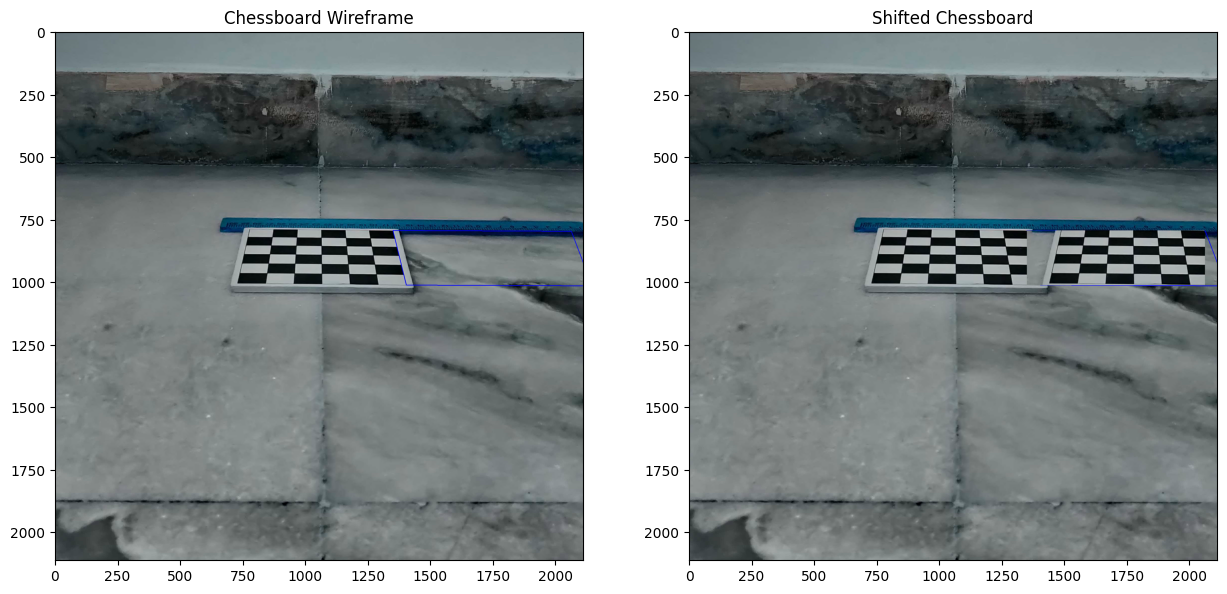

In [45]:
## Question - 3

image_path = 'assign1.jpg'  
chessboard_size = (5, 5)  
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)

image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

if ret:
    corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    obj_points = [] 
    img_points = [corners]
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    obj_points.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    R = cv2.Rodrigues(rvecs[0])[0]
    t = tvecs[0]
    Rt = np.hstack((R, t))
    P = np.dot(mtx, Rt)
    objp = np.array([[5.0,-1.0,0.0],[11.0,-1.0,0.0],[5.0,5.0,0.0],[11.0,5.0,0.0]])
    img_points_3d = cv2.projectPoints(objp, rvecs[0], tvecs[0], mtx, dist)[0]
    img_points_3d = np.int32(img_points_3d).reshape(-1, 2)
    img_points_3d = np.array([[1349, 796],[2061, 799],[2144, 1017],[1402, 1014]])
    print(img_points_3d)
    axs[0].imshow(cv2.polylines(image, [img_points_3d], isClosed=True, color=(0, 0, 255), thickness=2))
    axs[0].set_title('Chessboard Wireframe')
else:
    print("Chessboard corners not found in the image.")

def shift_region(image, source_vertices, target_vertices, shift):
    shifted_image = image.copy()
    j,i = target_vertices[0]
    dj = 0
    for x in range(i, source_vertices[2][1] + 1):
        for y in range(shift+1):
            shifted_image[x, j + y + dj] = image[x, j + y - shift + dj]         

    return shifted_image

shift = 710
source = np.array([[1349 - shift, 796],[2061 - shift, 799],[2144 - shift, 1014],[1402 - shift, 1014]],  dtype=np.int32)
target = np.array([[1349, 796],[2061, 799],[2144, 1017],[1402, 1014]],  dtype=np.int32)
shifted_image = shift_region(image, source, target, shift)

axs[1].set_title('Shifted Chessboard')
axs[1].imshow(shifted_image)